                            به نام خدا                       

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

1. آموزش یک شبکه عصبی پیچشی برای دسته‌بندی تصاویر مجموعه داده Linnaeus 5

In [3]:
transform = transforms.Compose([
    #transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [4]:
dataset = datasets.ImageFolder('./data/Linnaeus 5 128X128/train', transform=transform)
test_dataset = datasets.ImageFolder('./data/Linnaeus 5 128X128/test', transform=transform)

In [5]:
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [7]:
len(train_loader), len(val_loader), len(test_loader)

(169, 19, 63)

In [7]:
from models import CNNModel

In [8]:
num_epochs = 10

learning_rate = 0.001

In [8]:
model = CNNModel()

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # آموزش
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # اعتبارسنجی
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/10, Train Loss: 1.5522, Train Acc: 31.06%, Val Loss: 1.4730, Val Acc: 40.50%
Epoch 2/10, Train Loss: 1.4312, Train Acc: 45.48%, Val Loss: 1.4201, Val Acc: 46.67%
Epoch 3/10, Train Loss: 1.3838, Train Acc: 50.41%, Val Loss: 1.3775, Val Acc: 50.83%
Epoch 4/10, Train Loss: 1.3484, Train Acc: 54.39%, Val Loss: 1.3716, Val Acc: 51.00%
Epoch 5/10, Train Loss: 1.3329, Train Acc: 56.35%, Val Loss: 1.3814, Val Acc: 51.17%
Epoch 6/10, Train Loss: 1.3124, Train Acc: 58.37%, Val Loss: 1.3548, Val Acc: 54.17%
Epoch 7/10, Train Loss: 1.2973, Train Acc: 60.11%, Val Loss: 1.3353, Val Acc: 56.17%
Epoch 8/10, Train Loss: 1.2801, Train Acc: 61.85%, Val Loss: 1.3529, Val Acc: 53.83%
Epoch 9/10, Train Loss: 1.2902, Train Acc: 60.85%, Val Loss: 1.3437, Val Acc: 55.83%
Epoch 10/10, Train Loss: 1.2527, Train Acc: 64.78%, Val Loss: 1.3454, Val Acc: 54.00%


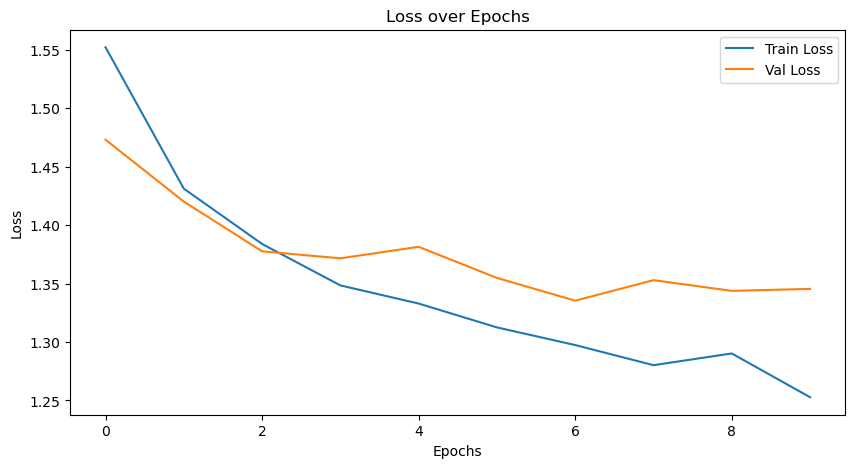

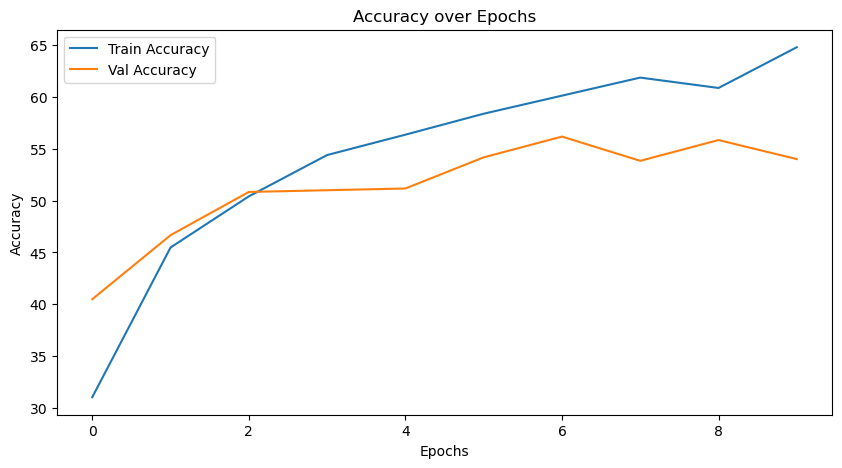

In [11]:
# نمودار خطا
plt.figure(figsize=(10,5))
plt.title("Loss over Epochs")
plt.plot(train_losses,label="Train Loss")
plt.plot(val_losses,label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# نمودار دقت
plt.figure(figsize=(10,5))
plt.title("Accuracy over Epochs")
plt.plot(train_accuracies,label="Train Accuracy")
plt.plot(val_accuracies,label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

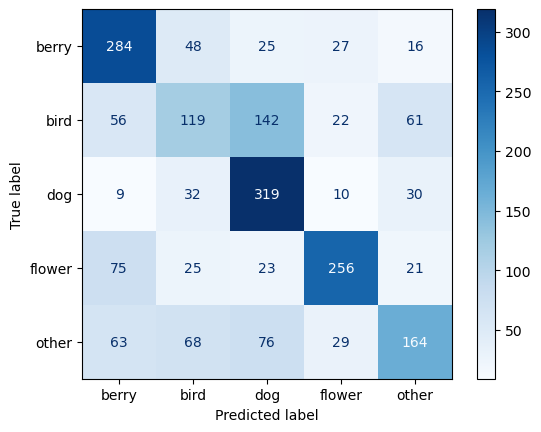

In [12]:

# پیش‌بینی روی مجموعه آزمون
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# محاسبه ماتریس درهم‌ریختگی
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


2. افزودن اتصال‌های باقیماندگی به شبکه و تحلیل تغییرات

In [1]:
from models import ResidualCNN

residual_model = ResidualCNN()

In [10]:
residual_criterion = nn.CrossEntropyLoss()
residual_optimizer = optim.Adam(residual_model.parameters(), lr=learning_rate)

In [11]:
residual_train_losses, residual_val_losses = [], []
residual_train_accuracies, residual_val_accuracies = [], []

for epoch in range(num_epochs):
    # آموزش
    residual_model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        
        residual_optimizer.zero_grad()
        outputs = residual_model(images)
        loss = residual_criterion(outputs, labels)
        loss.backward()
        residual_optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    residual_train_losses.append(train_loss)
    residual_train_accuracies.append(train_accuracy)
    
    # اعتبارسنجی
    residual_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = residual_model(images)
            loss = residual_criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total
    residual_val_losses.append(val_loss)
    residual_val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch 1/10, Train Loss: 1.2840, Train Acc: 46.06%, Val Loss: 1.2066, Val Acc: 49.50%
Epoch 2/10, Train Loss: 1.1682, Train Acc: 52.72%, Val Loss: 1.2892, Val Acc: 46.67%
Epoch 3/10, Train Loss: 1.1212, Train Acc: 55.44%, Val Loss: 1.0474, Val Acc: 59.67%
Epoch 4/10, Train Loss: 1.0575, Train Acc: 57.89%, Val Loss: 1.1576, Val Acc: 51.33%
Epoch 5/10, Train Loss: 1.0216, Train Acc: 60.52%, Val Loss: 1.1039, Val Acc: 56.50%
Epoch 6/10, Train Loss: 0.9603, Train Acc: 63.61%, Val Loss: 0.9865, Val Acc: 59.17%
Epoch 7/10, Train Loss: 0.9475, Train Acc: 64.28%, Val Loss: 0.9737, Val Acc: 64.50%
Epoch 8/10, Train Loss: 0.9176, Train Acc: 64.93%, Val Loss: 1.1016, Val Acc: 56.83%
Epoch 9/10, Train Loss: 0.8956, Train Acc: 66.15%, Val Loss: 1.0715, Val Acc: 58.83%
Epoch 10/10, Train Loss: 0.8886, Train Acc: 66.24%, Val Loss: 0.9340, Val Acc: 66.33%


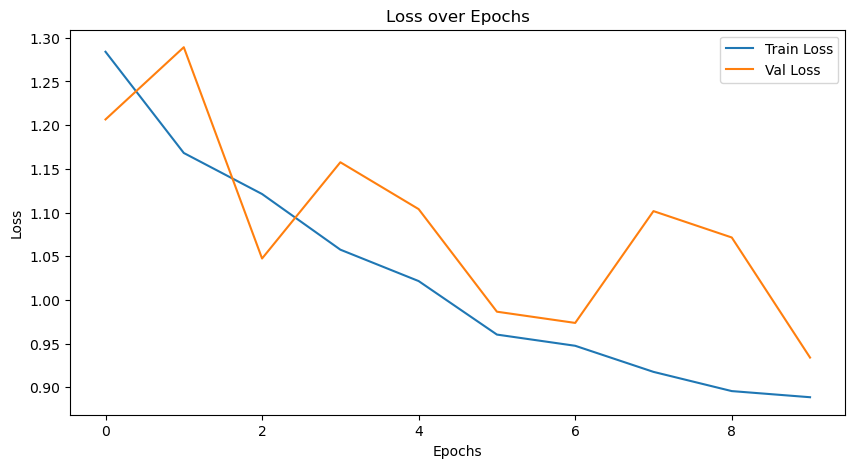

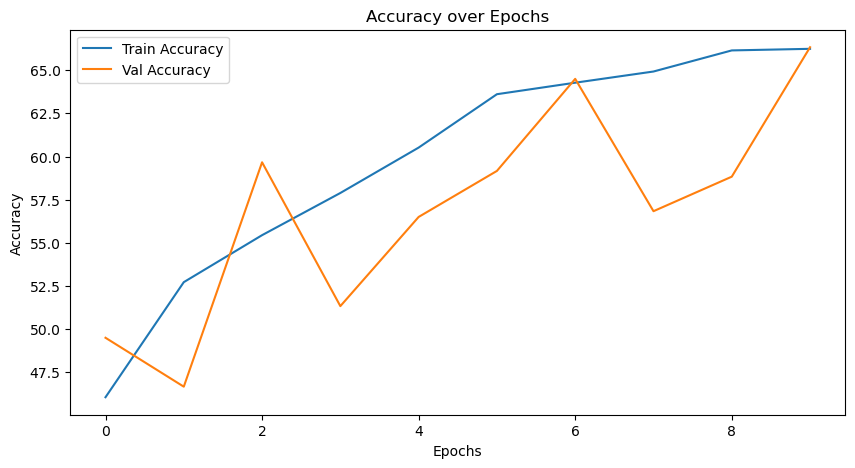

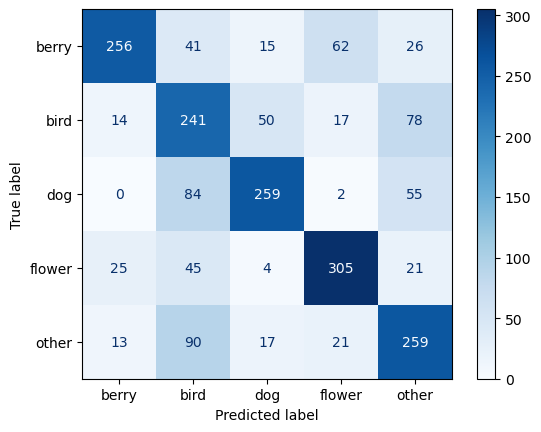

In [12]:
# نمودار خطا
plt.figure(figsize=(10,5))
plt.title("Loss over Epochs")
plt.plot(residual_train_losses,label="Train Loss")
plt.plot(residual_val_losses,label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# نمودار دقت
plt.figure(figsize=(10,5))
plt.title("Accuracy over Epochs")
plt.plot(residual_train_accuracies,label="Train Accuracy")
plt.plot(residual_val_accuracies,label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


# پیش‌بینی روی مجموعه آزمون
all_preds = []
all_labels = []

residual_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = residual_model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# محاسبه ماتریس درهم‌ریختگی
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
# دقت و سرعت همگرایی: انتظار می‌رود با افزودن اتصال‌های باقیماندگی، مدل عمیق‌تر بتواند بهتر آموزش ببیند و مشکل محو شدن گرادیان کاهش یابد.
# مقایسه نتایج: با مقایسه دقت و خطاها با مدل قبلی، می‌توان بهبود یا تغییرات را ارزیابی کرد.

In [18]:

class_names = dataset.classes


actual_labels = [class_names[label] for label in all_labels]
predicted_labels = [class_names[label] for label in all_preds]


df = pd.DataFrame({'Actual': actual_labels, 'Predicted': predicted_labels})

np.random.shuffle(df.values)

df.head(20)

,Actual,Predicted
0,dog,bird
1,dog,dog
2,berry,berry
3,flower,flower
4,other,other
5,berry,berry
6,berry,other
7,other,bird
8,berry,flower
9,other,bird


In [19]:
model = residual_model

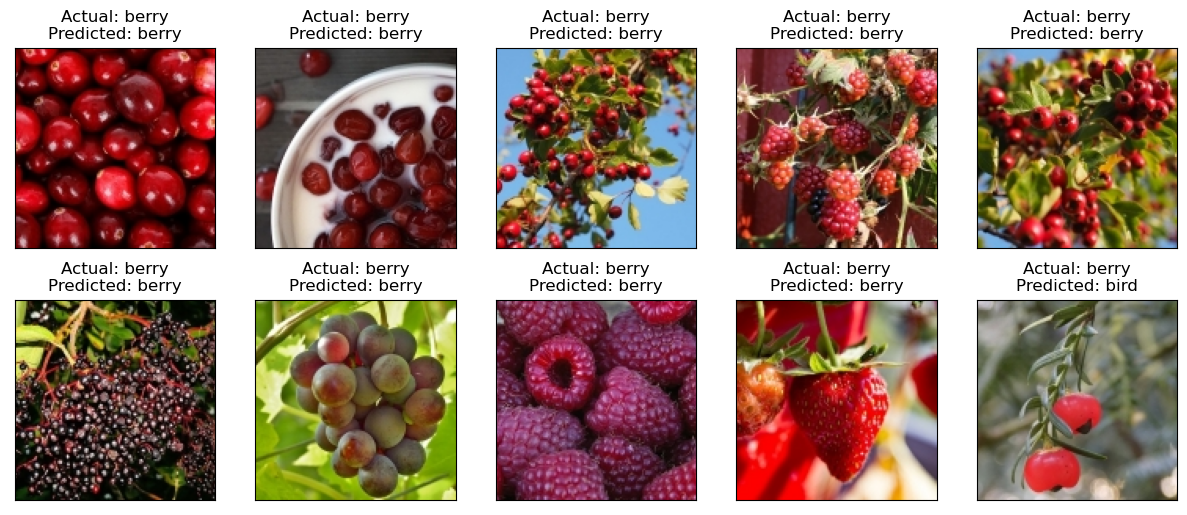

In [21]:

dataiter = iter(test_loader)
images, labels = next(dataiter)


outputs = model(images)
_, preds = torch.max(outputs, 1)


class_names = dataset.classes


fig = plt.figure(figsize=(15, 6))
for idx in range(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx].numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(f"Actual: {class_names[labels[idx]]}\nPredicted: {class_names[preds[idx]]}")

plt.show()

3. مصورسازی خروجی‌های لایه اول برای نشان دادن استخراج لبه‌ها

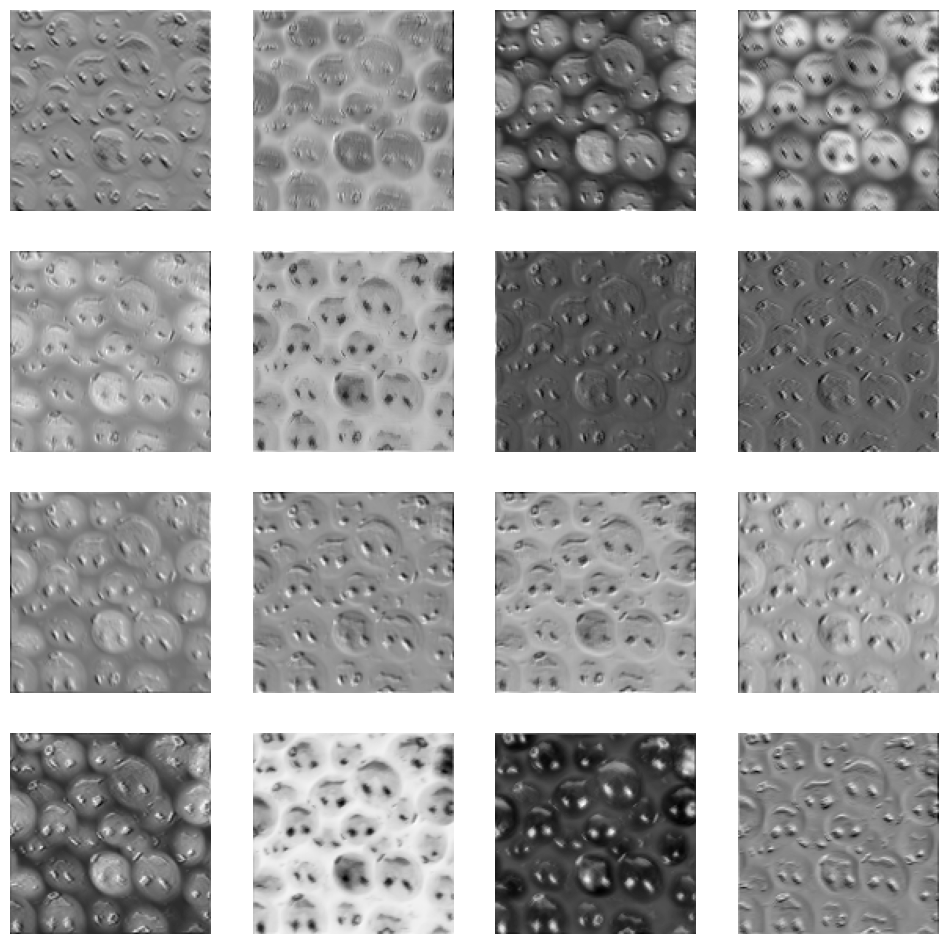

In [28]:
images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)

residual_model.eval()
with torch.no_grad():
    features = residual_model.layer1.conv1(image)

features = features.squeeze(0).cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    if i < features.shape[0]:
        ax.imshow(features[i], cmap='gray')
        ax.axis('off')
plt.show()

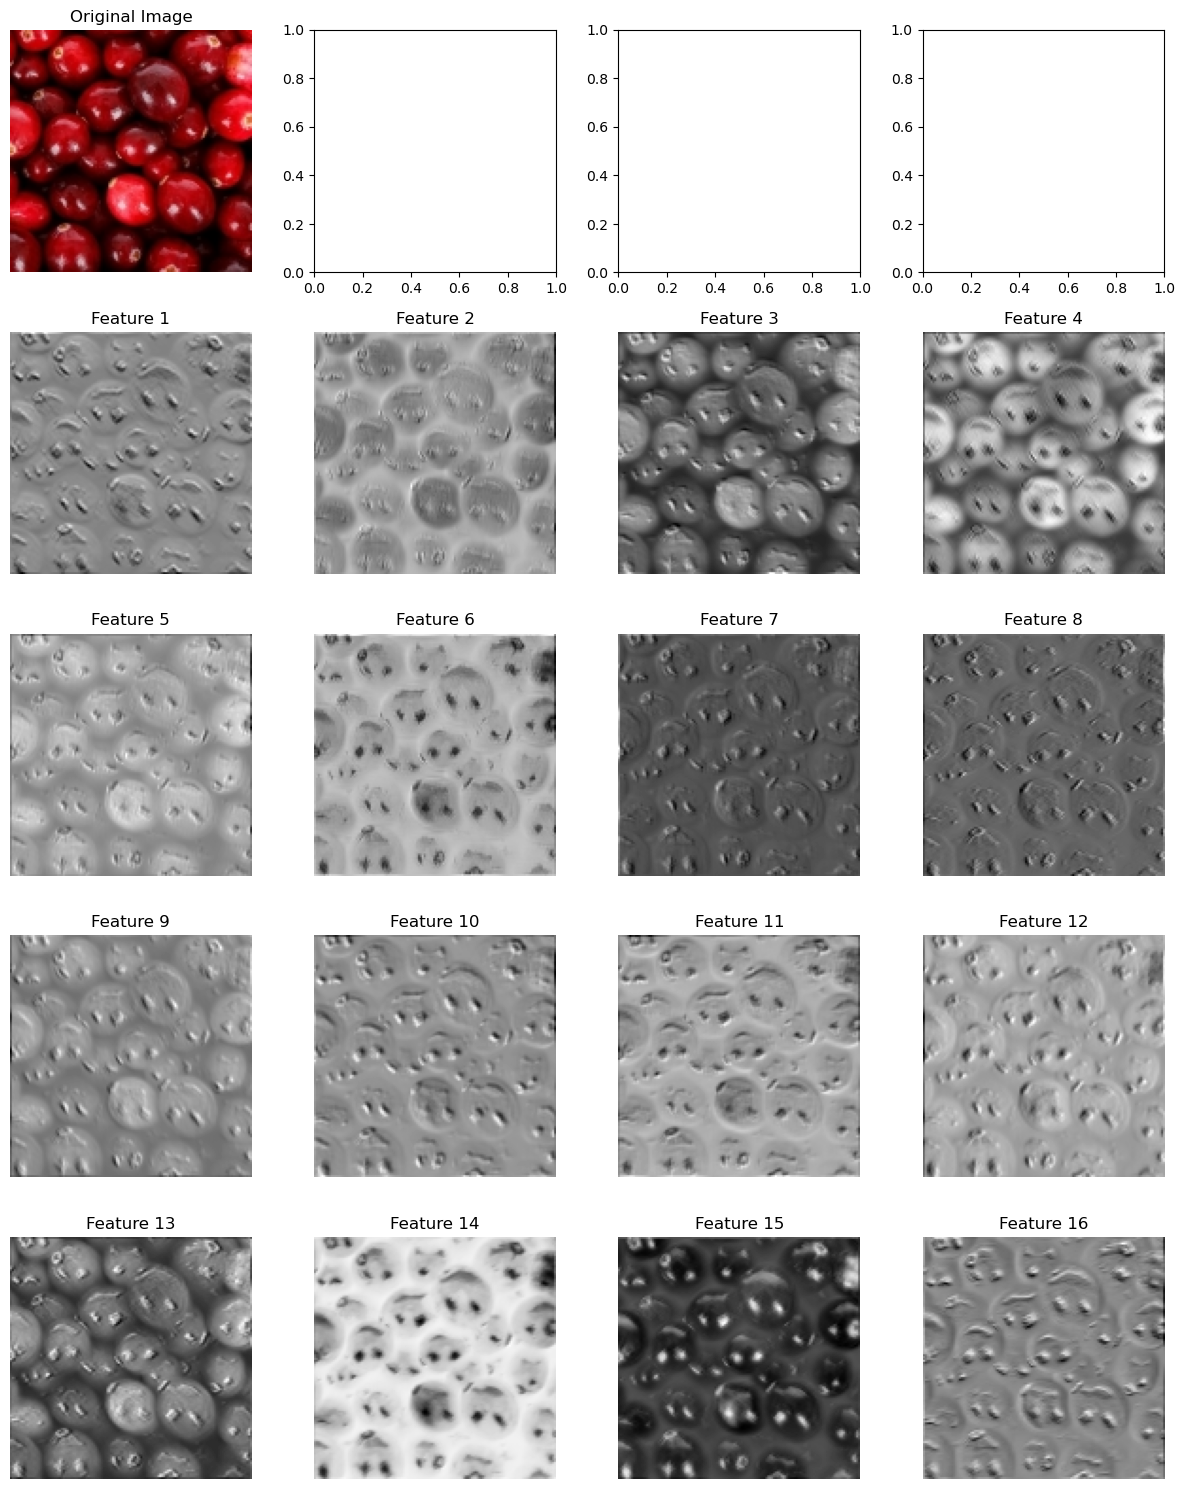

In [33]:


images, labels = next(iter(test_loader))
image = images[0].unsqueeze(0)

residual_model.eval()

with torch.no_grad():
    features = residual_model.layer1.conv1(image)

features = features.squeeze(0).cpu().numpy()

num_features = 16 

fig, axes = plt.subplots(5, 4, figsize=(12, 15))
axes = axes.flatten()


ax = axes[0]
img = images[0].permute(1, 2, 0).numpy()
img = np.clip(img, 0, 1)
ax.imshow(img)
ax.axis('off')
ax.set_title('Original Image')


for i in range(num_features):
    if i < features.shape[0]:
        ax = axes[i + 4]
        ax.imshow(features[i], cmap='gray')
        ax.axis('off')
        ax.set_title(f'Feature {i+1}')

for i in range(num_features + 4, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

4. جایگزینی لایه‌های Convolution با ساختار Inception و آموزش مجدد

In [34]:
from models import InceptionCNN

ImportError: cannot import name 'InceptionCNN' from 'models' (/home/user/Documents/Python/Python-Class/stu_probs/HW3/Linnaeus/models.py)

In [ ]:
model = InceptionCNN()